<a href="https://colab.research.google.com/github/FrankJRix/MF_gen_proto/blob/main/proc_gen_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
np.set_printoptions( linewidth=200)

N_ROOMS = 25
MAX_WEIGHT = 180
FRACTION = 0.4 # 0.3
SIGMA_FACTOR = 0.1 # 0.15

PHI_FACTOR = 1/2
THETA_FACTOR = 1/3

BIAS_ZER0 = MAX_WEIGHT / 10
BIAS_M = 0 # MAX_WEIGHT / 18

DISTRIBUTION_PLOT = True
PROOF_RUN = False

# classes

class Room:
    # room of the dungeon generator whatever
    global_id = 0
    def __init__(self, lr, ud):
        type(self).global_id += 1
        self.id = type(self).global_id
        self.instance_id = -1

        self.angle_lr = lr
        self.angle_ud = ud # might not be an angle
        self.base_weight = 1/2/PHI_FACTOR*lr + 1/2/THETA_FACTOR*ud # experimental #######################################################################################################################
        self.weight_modifier = 1 # placeholder

        self.up = []
        self.down = []
        self.left = []
        self.right = []

        self.pos = [0,0,0]
        self.rotation = 0

        self.can_walk_back = False
        self.can_fly_back = False

    def get_copy(self):
        r = Room(self.angle_lr, self.angle_ud)
        r.id = self.id
        r.can_walk_back = self.can_walk_back
        r.can_fly_back = self.can_fly_back

        return r

    def set_instance_id(self, id):
        self.instance_id = id

    def reset(self):
        self.up = []
        self.down = []
        self.left = []
        self.right = []

        self.pos = [0,0,0]
        self.rotation = 0

        self.can_walk_back = False
        self.can_fly_back = False

    def __str__(self):
        return f"instance_id: {self.instance_id}, id: {self.id}, lr: {self.angle_lr}, ud: {self.angle_ud}, up: {get_ids_from_list(self.up)}, down: {get_ids_from_list(self.down)}, left: {get_ids_from_list(self.left)}, right: {get_ids_from_list(self.right)}, pos: {self.pos}, rotation: {self.rotation}, base_weight: {self.base_weight}"

N = 20
class RoomBin:
    def __init__(self, inf, sup):
        self.inf = inf
        self.sup = sup
        self.content = []

    def get_fullness(self):
        return len(self.content) >= N

    def get_room(self):
        i = np.random.randint(0, len(self.content))
        return self.content[i].get_copy()

    def __str__(self):
        return f"[{self.inf}, {self.sup}); contains {len(self.content)} rooms"

class RoomPool:
    def __init__(self, n_bins):
        self.n_bins = n_bins
        self.bin_size = MAX_WEIGHT / n_bins
        self.bins = []
        self.populate()

    def select_bin(self, score):
        for b in self.bins:
            if score >= b.inf and score <= b.sup:
                return b

    def get_room(self, score):
        b = self.select_bin(score)
        return b.get_room()

    def get_fullness(self):
        a = True
        for bin in self.bins:
            a = a and bin.get_fullness()
        return a

    def populate(self):
        Room.global_id = 0
        self.bins = []
        for i in range(self.n_bins):
            b = RoomBin(self.bin_size*i, self.bin_size*(i+1))
            self.bins.append(b)

        while not self.get_fullness():
            phi = np.random.randint(-BIAS_ZER0, MAX_WEIGHT+BIAS_M) * PHI_FACTOR
            theta = np.random.randint(-BIAS_ZER0, MAX_WEIGHT+BIAS_M) * THETA_FACTOR

            phi = max(0, phi)
            phi = min(phi, MAX_WEIGHT*PHI_FACTOR)
            theta = max(0, theta)
            theta = min(theta, MAX_WEIGHT*THETA_FACTOR)

            r = Room(phi, theta)
            b = self.select_bin(r.base_weight)
            if not b.get_fullness():
                b.content.append(r)

class Path:
    def __init__(self):
        self.rooms = []

    # <- overridare add e sub per combinare paths in mappa totale e subpath differenziale

    def __len__(self):
        return len(self.rooms)

    def __getitem__(self, key):
        return self.rooms[key]

    def __setitem__(self, key, value):
        self.rooms[key] = value

    def append(self, item):
        self.rooms.append(item)

    def print(self):
        for r in self.rooms:
            print(r)
            print()

class Map:
    def __init__(self, pool):
        self.pool = pool
        self.global_positions = []
        self.main_path = Path()

        self.phase_one()

    def flush(self):
        self.global_positions = []
        for r in self.main_path:
            r.reset()
        self.main_path = Path()

    def draw(self, uniform = False, save = False):
        # implementazione provvisoria a path singolo
        margin = 5
        map = np.array(self.global_positions)
        mn = min(map[:,0].min(), map[:,1].min()) - margin
        mx = max(map[:,0].max(), map[:,1].max()) + margin
        minz = map[:,2].min() - margin
        maxz = map[:,2].max() + margin

        if uniform:
            minz = min(-abs(mx - mn), minz)

        a = plt.figure(figsize = (10,10))

        plt.subplot(2, 2, 1)
        plt.scatter(map[:,0], map[:,1], marker='.', color='black')
        plt.plot(map[:,0], map[:,1], linestyle='--', color='black', alpha=0.2)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim(mn, mx)
        plt.ylim(mn, mx)
        plt.grid(linestyle = '-.')
        for i in range(len(self.main_path)):
            plt.annotate(f"{self.main_path[i].instance_id}", xy=(map[i,0], map[i,1]), xytext=(map[i,0]-1, map[i,1]+1))

        plt.subplot(2, 2, 4)
        plt.scatter(map[:,1], map[:,2], marker='.', color='black')
        plt.plot(map[:,1], map[:,2], linestyle='--', color='black', alpha=0.2)
        plt.xlabel('y')
        plt.ylabel('z')
        plt.xlim(mn, mx)
        plt.ylim(minz, maxz)
        plt.grid(linestyle = '-.')

        plt.subplot(2, 2, 3)
        plt.scatter(map[:,0], map[:,2], marker='.', color='black')
        plt.plot(map[:,0], map[:,2], linestyle='--', color='black', alpha=0.2)
        plt.xlabel('x')
        plt.ylabel('z')
        plt.xlim(mn, mx)
        plt.ylim(minz, maxz)
        plt.grid(linestyle = '-.')

        ax = plt.subplot(2, 2, 2, projection='3d')
        ax.scatter(map[:,0], map[:,1], map[:,2], marker='x', color='black')
        ax.plot(map[:,0], map[:,1], map[:,2], linestyle='--', color='black', alpha=0.1)
        plt.xlabel('x')
        plt.ylabel('y')
        ax.axes.set_xlim3d(left=mn, right=mx)
        ax.axes.set_ylim3d(bottom=mn, top=mx)
        ax.axes.set_zlim3d(bottom=minz, top=maxz)

        a.suptitle(f"N_ROOMS = {N_ROOMS}, MAX_WEIGHT = {MAX_WEIGHT}, FRACTION = {FRACTION}, SIGMA_FACTOR = {SIGMA_FACTOR}")
        plt.tight_layout()
        if save:
            plt.savefig("mf_dungeon_test.pdf", bbox_inches='tight')
        plt.show()

    def phase_one(self):
        self.flush()

        for i in range(N_ROOMS):
            p = self.pool
            x = slifat_normal(i)
            x = max(0, x)
            x = min(x, MAX_WEIGHT)
            r = p.get_room(x)

            r.set_instance_id(i)
            self.main_path.append(r)

            if i != 0:
                r.up.append(self.main_path[i-1])
                self.main_path[i-1].down.append(r)

        D = 5 # poi sarà somma delle lunghezze delle stanze blablah
        for i in range(len(self.main_path)-1):
            self.main_path[i+1].pos[0] = self.main_path[i].pos[0] + D * np.cos( np.radians( self.main_path[i].rotation ) ) * np.cos( np.radians( self.main_path[i].angle_ud ) )
            self.main_path[i+1].pos[1] = self.main_path[i].pos[1] + D * np.sin( np.radians( self.main_path[i].rotation ) ) * np.cos( np.radians( self.main_path[i].angle_ud ) )
            self.main_path[i+1].pos[2] = self.main_path[i].pos[2] - D * np.sin( np.radians( self.main_path[i].angle_ud ) )

            self.main_path[i+1].rotation = (self.main_path[i].rotation + self.main_path[i+1].angle_lr) % 360

        for i in range(len(self.main_path)):
            self.global_positions.append(self.main_path[i].pos)

        self.draw()

class PartitionGrid:
    edge = 5
    def __init__(self, map):
        # partiziona spazio
        margin = 10
        edge = PartitionGrid.edge

        coords = np.array(map.global_positions)
        min_xy = min(coords[:,0].min(), coords[:,1].min()) - margin
        max_xy = max(coords[:,0].max(), coords[:,1].max()) + margin
        min_z = coords[:,2].min() - margin
        max_z = coords[:,2].max() + margin

        self.map = map
        self.origin = np.array([min_xy, min_xy, max_z])
        self.width = abs(max_xy - min_xy)
        self.height = abs(max_z - min_z)

        ### non serve a un cazzo lol
        xy_boundaries = np.array([min_xy, max_xy])
        z_boundaries = np.array([min_z, max_z])

        vertices = build_box(xy_boundaries, xy_boundaries, z_boundaries)
        ### forse dovrei toglie

        self.n = int(self.width / edge)
        self.m = int(self.height / edge)
        self.grid = np.zeros((self.m,self.n,self.n))

        self.populate()

    def populate(self):
        coords = np.array(self.map.global_positions)
        edge = PartitionGrid.edge
        # ottimizzabile, pesantemente
        for k in range(self.m):
            for j in range(self.n):
                for i in range(self.n):
                    for room in coords:
                        xb = [i * edge, (i+1) * edge]
                        yb = [j * edge, (j+1) * edge]
                        zb = [-k * edge, -(k+1) * edge]
                        box = build_box(xb,yb,zb)
                        if is_inside(self.to_grid(room), box):
                            self.grid[k,j,i] = 1

    def to_grid(self, pos):
        return pos - self.origin

    def to_map(self, pos):
        return pos + self.origin

class Graph:
    def __init__(self, *args):
        # members...
        if isinstance(args[0], Map):
            # partiziona spazio
            grid = PartitionGrid(args[0])
        elif isinstance(args[0], Path):
            # costruisci da path
            pass
        else:
            # boh, error
            pass

# functions

def get_ids_from_list(list):
    ids = []
    for e in list:
        ids.append(f"{e.id}, {e.instance_id}")
    return ids

def compute_sfn_parameters(n):
    M = MAX_WEIGHT
    N = N_ROOMS

    m = FRACTION * M/N

    mu = m * n
    sigma = SIGMA_FACTOR * (M + M*n/N)

    return mu, sigma

def slifat_normal(step, dim = 1):
    mu, sigma = compute_sfn_parameters(step)

    return np.random.normal(mu, sigma, dim).round().item()

def slifat_normal_fun(t, step):
    mu, sigma = compute_sfn_parameters(step)

    return np.sqrt(1 / (2 * np.pi * sigma**2)) / np.exp((t - mu)**2 / (2 * sigma**2))

def build_box(xb, yb, zb):
    vertices = []

    for x in xb:
        for y in yb:
            for z in zb:
                vertices.append(np.array([x,y,z]))
    vertices = np.array(vertices)
    return vertices

def is_inside(point, box):
    v = True
    for i in range(3):
        v = v and (point[i]) >= box[:,i].min() and point[i] <= box[:,i].max()
    return v



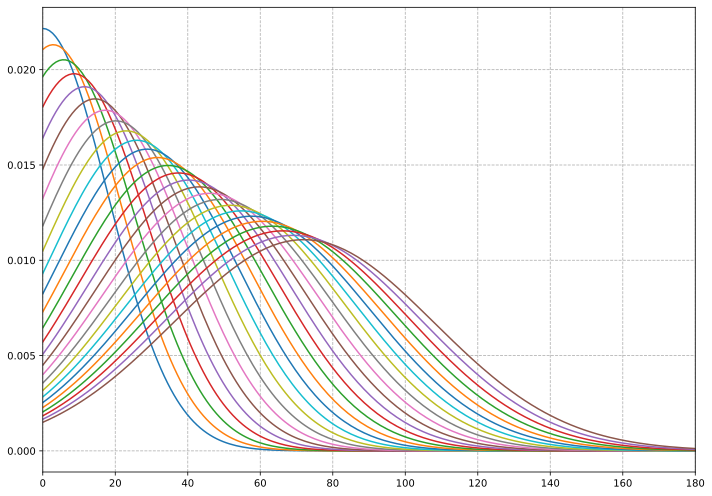

In [157]:
# @title Proof of concept
t = np.linspace(0, MAX_WEIGHT, 200)
dim = 1
dungeon = []

if DISTRIBUTION_PLOT:
    plt.figure(figsize=(10,7))
for step in range(N_ROOMS+1):
    if DISTRIBUTION_PLOT:
        plt.plot(t, slifat_normal_fun(t, step))

    w = max(0, slifat_normal(step, dim))
    w = min(w, MAX_WEIGHT)
    z = max(0, slifat_normal(step, dim))
    z = min(z, MAX_WEIGHT)

    dungeon.append(Room(w/2, z/4))

if DISTRIBUTION_PLOT:
    plt.grid(True, 'both', linestyle='--')
    plt.xlim(0, MAX_WEIGHT)
    plt.tight_layout()

D = 5
for i in range(len(dungeon)-1):

    dungeon[i+1].pos[0] = dungeon[i].pos[0] + D * np.cos( np.radians( dungeon[i].rotation ) )
    dungeon[i+1].pos[1] = dungeon[i].pos[1] + D * np.sin( np.radians( dungeon[i].rotation ) )

    dungeon[i+1].pos[2] = dungeon[i].pos[2] - D * np.sin( np.radians( dungeon[i].angle_ud ) )
    dungeon[i+1].rotation = (dungeon[i].rotation + dungeon[i+1].angle_lr) % 360

map = []
for r in dungeon:
    map.append(r.pos)
map = np.array(map)

In [158]:
# @title Proof of concept

if PROOF_RUN:
    mn = min(map[:,0].min(), map[:,1].min())
    mx = max(map[:,0].max(), map[:,1].max())

    a = plt.figure(figsize = (10,10))

    plt.subplot(2, 2, 1)
    plt.scatter(map[:,0], map[:,1], marker='.', color='black')
    plt.plot(map[:,0], map[:,1], linestyle='--', color='black', alpha=0.2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(mn-2, mx+2)
    plt.ylim(mn-2, mx+2)
    plt.grid(linestyle = '-.')
    for i in range(len(dungeon)):
        plt.annotate(f"{dungeon[i].id}", xy=(map[i,0], map[i,1]), xytext=(map[i,0]-1, map[i,1]+1))

    plt.subplot(2, 2, 4)
    plt.scatter(map[:,1], map[:,2], marker='.', color='black')
    plt.plot(map[:,1], map[:,2], linestyle='--', color='black', alpha=0.2)
    plt.xlabel('y')
    plt.ylabel('z')
    plt.xlim(mn-2, mx+2)
    plt.ylim(map[:,2].min()-2, map[:,2].max()+2)
    plt.grid(linestyle = '-.')

    plt.subplot(2, 2, 3)
    plt.scatter(map[:,0], map[:,2], marker='.', color='black')
    plt.plot(map[:,0], map[:,2], linestyle='--', color='black', alpha=0.2)
    plt.xlabel('x')
    plt.ylabel('z')
    plt.xlim(mn-2, mx+2)
    plt.ylim(map[:,2].min()-2, map[:,2].max()+2)
    plt.grid(linestyle = '-.')

    ax = plt.subplot(2, 2, 2, projection='3d')
    ax.scatter(map[:,0], map[:,1], map[:,2], marker='x', color='black')
    ax.plot(map[:,0], map[:,1], map[:,2], linestyle='--', color='black', alpha=0.1)
    plt.xlabel('x')
    plt.ylabel('y')

    a.suptitle(f"N_ROOMS = {N_ROOMS}, MAX_WEIGHT = {MAX_WEIGHT}, FRACTION = {FRACTION}, SIGMA_FACTOR = {SIGMA_FACTOR}")
    plt.tight_layout()
    #plt.savefig("mf_dungeon_test.pdf", bbox_inches='tight')
    plt.show()

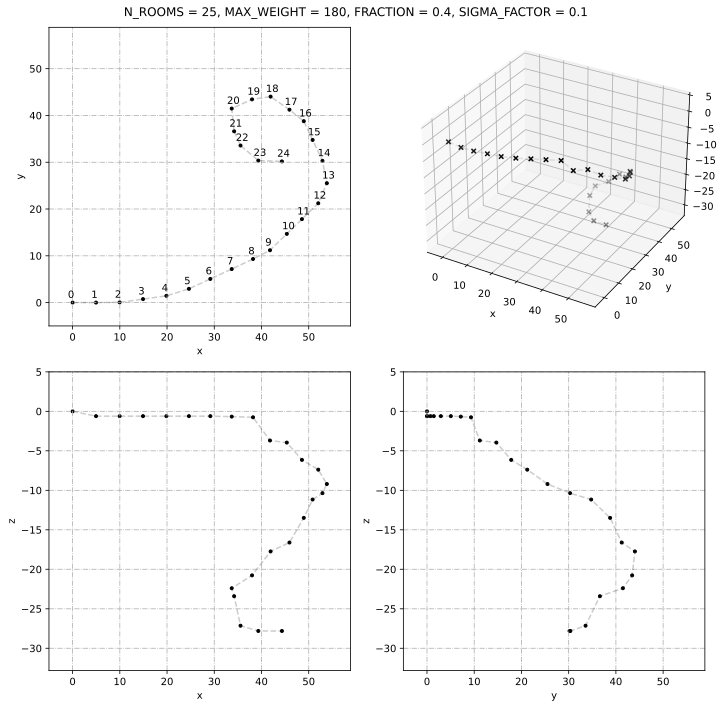

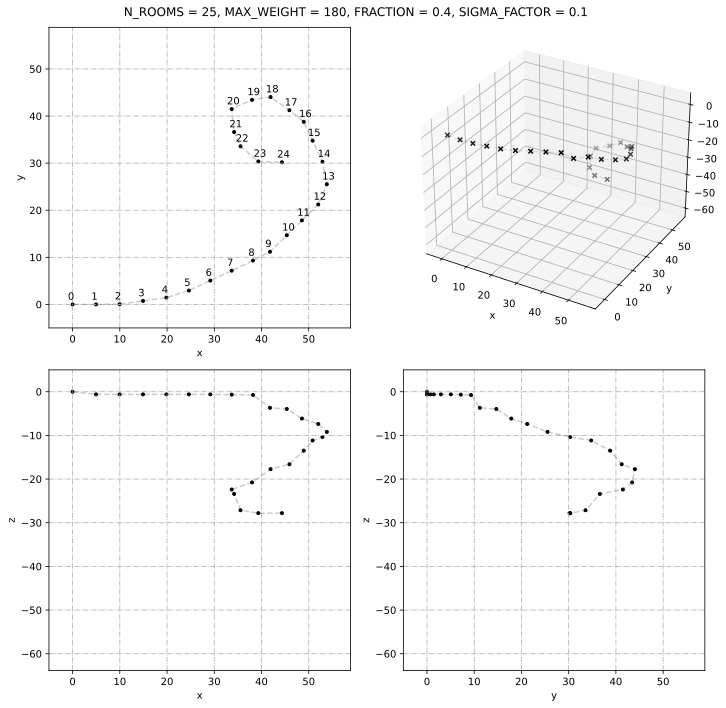

In [159]:
# @title Prototype
a = RoomPool(20)
a.populate()
mappa = Map(a)
mappa.draw(True)

# print(len(a.bins))
# for b in a.bins:
#     print(b)
#     for r in b.content:
#         print(r)
#     print()

# print(a.get_fullness())

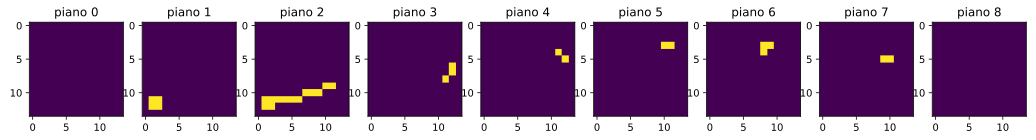

In [160]:
g = PartitionGrid(mappa)

plt.figure(figsize = (20,6))
for i in range(g.grid.shape[0]):
    plt.subplot(2,10,i+1)
    plt.imshow(np.flipud(g.grid[i]))
    plt.title(f"piano {i}")
plt.show()

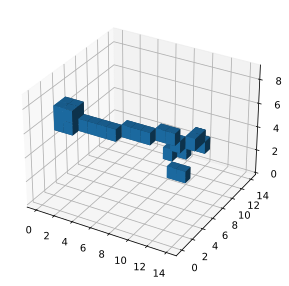

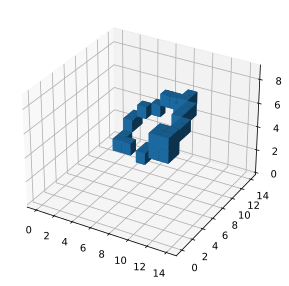

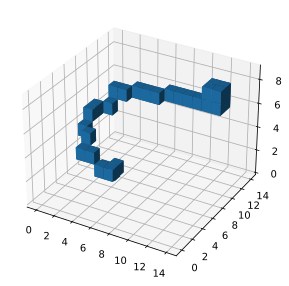

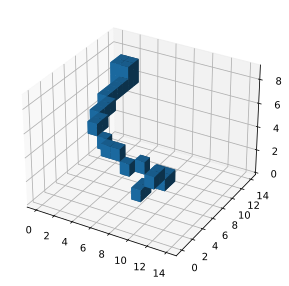

In [161]:
vox = g.grid
vox = np.rot90(g.grid, k=3, axes=(0,2))

for i in range(4):
    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(vox, alpha=1)
    plt.show()
    vox = np.rot90(vox, k=1, axes=(0,1))